In [42]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
import helper 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.datasets import make_classification

## Data Modeling Workflow
The following workflow will be applied in building the data model:
1.  Extract tests at assessment and weeks 0 - 4 for treatment<br>
2.  Extract surveys at assessment and weeks 0, 4 for treatment
3.  Extract Other Numeric Baseline Predictors, including:
    - attendence
    - medication dose
    - clinical opiate withdrawal scale - score of 1 - 13, lower score shows lower withdrawal symptoms
4.  Extract Catagorical Baseline Predictors, including:
    - Demographics
    - Substance Use Diagnosis
    - Mental and Pysical Health History
    - Physical Exam

## Load Data

In [43]:
# read csv file
data = pd.read_csv('../data/merged_data.csv')

print('Shape of dataframe prior to modeling:', data.shape)
display(data.head())

Shape of dataframe prior to modeling: (1917, 426)


,patdeid,rsa_week_0,rsa_week_1,rsa_week_2,rsa_week_3,rsa_week_4,rsa_week_5,rsa_week_6,rsa_week_7,rsa_week_8,...,pex_neurological,pex_gen_appearance,pex_ears_nose_throat,pex_head_neck,pex_cardio,pex_skin,medication,weeks_comp,cows_predose,cows_postdose
0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,normal,normal,normal,normal,normal,normal,2.0,27,11.0,6.0
1,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,normal,abnormal,abnormal,normal,normal,abnormal,2.0,27,8.0,1.0
2,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,normal,normal,normal,normal,normal,abnormal,1.0,27,8.0,5.0
3,4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,normal,normal,normal,normal,normal,normal,2.0,27,11.0,9.0
4,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,not_present,not_present,not_present,not_present,not_present,not_present,2.0,1,0.0,0.0


## Review Tests

In [44]:
test_names = [
 #'Propoxyphene',
 'Amphetamines',
 'Cannabinoids',
 'Benzodiazepines',
 #'MMethadone',
 #'Oxycodone',
 'Cocaine',
 'Methamphetamine',
 #'Opiate300'
 ]

# define prefix parameter and call helper function to build the dataset
prefix = 'test_'
tests = helper.feature_selection(data, prefix, test_names)

Shape of tests DataFrame: (1917, 25)


,test_Amphetamines_0,test_Cannabinoids_0,test_Benzodiazepines_0,test_Cocaine_0,test_Methamphetamine_0,test_Amphetamines_1,test_Cannabinoids_1,test_Benzodiazepines_1,test_Cocaine_1,test_Methamphetamine_1,...,test_Amphetamines_3,test_Cannabinoids_3,test_Benzodiazepines_3,test_Cocaine_3,test_Methamphetamine_3,test_Amphetamines_4,test_Cannabinoids_4,test_Benzodiazepines_4,test_Cocaine_4,test_Methamphetamine_4
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1914,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1915,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## Review Surveys


In [45]:
# comment out the drugs you don't want to include
survey_names = [
'cannabis',
'cocaine',
'alcohol',
#'oxycodone',
#'mmethadone',
'amphetamine',
'methamphetamine',
#'opiates',
'benzodiazepines'
]

# call helper function to build  the dataset
prefix = 'survey_'
surveys = helper.feature_selection(data, prefix, survey_names)

Shape of tests DataFrame: (1917, 12)


,survey_cannabis_0,survey_cocaine_0,survey_alcohol_0,survey_amphetamine_0,survey_methamphetamine_0,survey_benzodiazepines_0,survey_cannabis_4,survey_cocaine_4,survey_alcohol_4,survey_amphetamine_4,survey_methamphetamine_4,survey_benzodiazepines_4
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,23.0,0.0,0.0,0.0,0.0,0.0,9.0,18.0,0.0,0.0,0.0
3,1.0,2.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1913,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Create Dataframe for Baseline Numeric Predictors

In [46]:
# attendance data, included up to week 4
rsa = data[[col for col in data.columns if 'rsa' in col]].iloc[:, :5]

# medication data, included up to week 4
meds = data[[col for col in data.columns if 'med' in col]].iloc[:, :10]

# clinical opiate withdrawal scale -  included for baseline and week 0
cows = data[[col for col in data.columns if 'cows' in col]]

# create dataframe with numeric features
num_df = pd.concat([tests, surveys, rsa, meds, cows], axis=1)

print('Shape of numeric dataframe',num_df.shape)
display(num_df)

Shape of numeric dataframe (1917, 54)


,test_Amphetamines_0,test_Cannabinoids_0,test_Benzodiazepines_0,test_Cocaine_0,test_Methamphetamine_0,test_Amphetamines_1,test_Cannabinoids_1,test_Benzodiazepines_1,test_Cocaine_1,test_Methamphetamine_1,...,meds_methadone_1,meds_buprenorphine_1,meds_methadone_2,meds_buprenorphine_2,meds_methadone_3,meds_buprenorphine_3,meds_methadone_4,meds_buprenorphine_4,cows_predose,cows_postdose
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,160.0,0.0,320.0,0.0,192.0,0.0,384.0,11.0,6.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,48.0,0.0,48.0,0.0,60.0,0.0,48.0,8.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,170.0,0.0,310.0,0.0,420.0,0.0,360.0,0.0,8.0,5.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,152.0,0.0,192.0,0.0,160.0,0.0,64.0,11.0,9.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,152.0,0.0,192.0,0.0,160.0,0.0,64.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,270.0,0.0,250.0,0.0,300.0,0.0,360.0,0.0,0.0,0.0
1913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,160.0,0.0,112.0,0.0,112.0,0.0,112.0,17.0,12.0
1914,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,160.0,0.0,112.0,0.0,112.0,0.0,112.0,0.0,0.0
1915,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,160.0,0.0,112.0,0.0,112.0,0.0,112.0,0.0,0.0


## Review Categorical Data

In [47]:
# demographic data
dem = data[[col for col in data.columns if col.startswith('dem_')]]
#dem = pd.get_dummies(dem, dtype=int)
# create df for diagnosis
dsm = data[[col for col in data.columns if col.startswith('dsm_')]]
#dsm = pd.get_dummies(dsm, dtype=int)
# create df for medical history
#mdh = data[[col for col in data.columns if col.startswith('mdh_')]]
#mdh = pd.get_dummies(mdh, dtype=int)

# create df for physical exam
#pex = data[[col for col in data.columns if col.startswith('pex_')]]
#pex = pd.get_dummies(pex, dtype=int)

# concat cat features into cat_df
cat_df = pd.concat([dem, dsm], axis=1)

print('shape of the categorical df:',cat_df.shape)
display(cat_df)

shape of the categorical df: (1917, 16)


,dem_gender,dem_ethnicity,dem_race_no_answer,dem_race_unknown,dem_race_amer_ind,dem_race_asian,dem_race_black,dem_race_pacific_islander,dem_race_white,dem_race_other,dsm_cannabis,dsm_cocaine,dsm_sedative,dsm_opiates,dsm_alcohol,dsm_amphetamine
0,male,not_spanish_origin,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated
1,male,not_spanish_origin,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated
2,male,not_spanish_origin,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated
3,female,not_spanish_origin,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,no_diagnosis,no_diagnosis,no_diagnosis,dependence,no_diagnosis,no_diagnosis
4,male,not_spanish_origin,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,not_present,not_present,not_present,not_present,not_present,not_present
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,female,not_spanish_origin,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,no_diagnosis,no_diagnosis,no_diagnosis,dependence,no_diagnosis,no_diagnosis
1913,male,not_spanish_origin,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,no_diagnosis,no_diagnosis,no_diagnosis,dependence,no_diagnosis,no_diagnosis
1914,female,not_spanish_origin,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,not_present,not_present,not_present,not_present,not_present,not_present
1915,male,not_spanish_origin,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,no_diagnosis,abuse,dependence,dependence,abuse,abuse


### We found some noisy data in this dataset
There were two different imputations applied to dsm columns<br>
Combine 'not_present' and 'not_evaluated' to 'not_evaluated'<br>
There is a 0 value in `dem_gender` in 3 rows, we will delete them<br>

In [ ]:
# replace values labeled 'not_present', with 'not_evaluated'
#cat_df = cat_df.replace('not_present', 'not_evaluated')

# remove rows with 0 values
#cat_df.loc[cat_df.dem_gender!='0']

#print(cat_df.shape)
#display(cat_df)

In [48]:
# one hot encode cat_df
cat_df = pd.get_dummies(cat_df, drop_first=True, dtype=float)

print(cat_df.shape)
display(cat_df)

(1917, 35)


,dem_race_no_answer,dem_race_unknown,dem_race_amer_ind,dem_race_asian,dem_race_black,dem_race_pacific_islander,dem_race_white,dem_race_other,dem_gender_female,dem_gender_male,...,dsm_opiates_not_evaluated,dsm_opiates_not_present,dsm_alcohol_dependence,dsm_alcohol_no_diagnosis,dsm_alcohol_not_evaluated,dsm_alcohol_not_present,dsm_amphetamine_dependence,dsm_amphetamine_no_diagnosis,dsm_amphetamine_not_evaluated,dsm_amphetamine_not_present
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1913,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1914,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1915,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Assign Target Variable and Combine

In [49]:
# assigne dropout variable
dropout = data['dropout']

# merge
new_data = pd.concat([num_df, cat_df, dropout], axis=1)

print('Shape of new datframe:',new_data.shape)
display(new_data)


Shape of new datframe: (1917, 90)


,test_Amphetamines_0,test_Cannabinoids_0,test_Benzodiazepines_0,test_Cocaine_0,test_Methamphetamine_0,test_Amphetamines_1,test_Cannabinoids_1,test_Benzodiazepines_1,test_Cocaine_1,test_Methamphetamine_1,...,dsm_opiates_not_present,dsm_alcohol_dependence,dsm_alcohol_no_diagnosis,dsm_alcohol_not_evaluated,dsm_alcohol_not_present,dsm_amphetamine_dependence,dsm_amphetamine_no_diagnosis,dsm_amphetamine_not_evaluated,dsm_amphetamine_not_present,dropout
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1914,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1915,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Save to CSV for ML Pipelines

In [ ]:
# save to csv
new_data.to_csv('../data/classification_df.csv', index=False)

## Classification Workflow

In [50]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import numpy as np


# create train, test and eval set
from fast_ml.model_development import train_valid_test_split
train = 0.7
test = 0.2
validation = 0.1
X_train, y_train, X_val, y_val, X_test, y_test = train_valid_test_split(new_data,
                      target='dropout',
                      train_size=train,                        
                      test_size=test,
                      valid_size=validation)

# print shape of all data sets
print('Shape of X_train:', X_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of X_test:', X_test.shape)

Shape of X_train: (1341, 89)
Shape of X_val: (192, 89)
Shape of X_test: (384, 89)


In [51]:
gbm_param_grid = {
	'learning_rate': [0.01, 0.1, 0.5, 0.9],
	'n_estimators': [200, 300, 400],
    'max_depth': [3, 6, 9],
	'objective': ['binary:logistic']  # Specify binary logistic objective
}

gbm = xgb.XGBClassifier(use_label_encoder=False)  # XGBClassifier for classification tasks
grid_auc = GridSearchCV(estimator=gbm, 
                        param_grid=gbm_param_grid, 
                        scoring='roc_auc', 
                        cv=5, 
                        verbose=1, 
                        return_train_score=True,
                        n_jobs=-1)  # Use ROC AUC as the scoring metric

grid_auc.fit(X_train, y_train)
print("Best parameters found: ", grid_auc.best_params_)
print("Highest ROC AUC found: ", grid_auc.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'objective': 'binary:logistic'}
Highest ROC AUC found:  0.8887317256962417


In [52]:
# refit the model with the best params
best_params = grid_auc.best_params_

# best model
best_gbm = xgb.XGBClassifier(**best_params)

# fit the model
best_gbm.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val, y_val)], eval_metric=['auc','error'], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

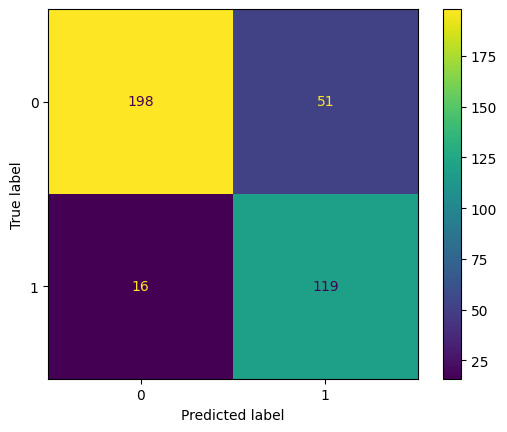

In [53]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = best_gbm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_gbm.classes_)
disp.plot();

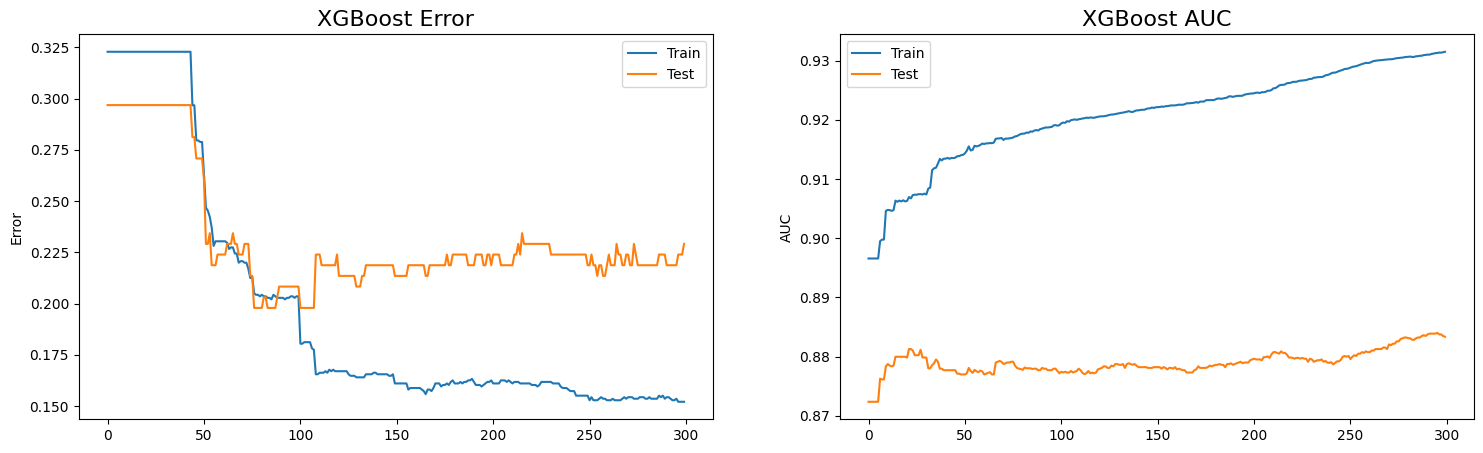

In [54]:
# retrieve performance metrics
results = best_gbm.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# plot log loss and classification error 
fig, axs = plt.subplots(ncols=2, figsize=(18, 5))

# plot log loss
axs[0].plot(x_axis, results['validation_0']['error'], label='Train')
axs[0].plot(x_axis, results['validation_1']['error'], label='Test')
axs[0].legend()
axs[0].set_ylabel('Error')
axs[0].set_title('XGBoost Error', fontsize=16)

# plot classification error
axs[1].plot(x_axis, results['validation_0']['auc'], label='Train')
axs[1].plot(x_axis, results['validation_1']['auc'], label='Test')
axs[1].legend()
axs[1].set_ylabel('AUC')
axs[1].set_title('XGBoost AUC', fontsize=16)

plt.show()


In [55]:
# make predictions to evaluate the model
y_pred_train = best_gbm.predict(X_train)
y_pred_val = best_gbm.predict(X_val)
y_pred_test = best_gbm.predict(X_test)

### Create DF with Train, Val and Test metrics

In [56]:
from sklearn.metrics import classification_report

# Assuming you have your predictions as y_pred_train, y_pred_val, y_pred_test
# and the true labels as y_train, y_val, y_test

# Generate classification reports
report_train = classification_report(y_train, y_pred_train, output_dict=True)
report_val = classification_report(y_val, y_pred_val, output_dict=True)
report_test = classification_report(y_test, y_pred_test, output_dict=True)

# Create DataFrames from reports
df_train = pd.DataFrame(report_train).transpose()
df_val = pd.DataFrame(report_val).transpose()
df_test = pd.DataFrame(report_test).transpose()

# Add a column to distinguish between datasets
df_train['dataset'] = 'Training'
df_val['dataset'] = 'Validation'
df_test['dataset'] = 'Test'

# Concatenate all three DataFrames
df_all = pd.concat([df_train, df_val, df_test], axis=0).reset_index()

# Rename 'index' column to something more descriptive, like 'metric'
df_all.rename(columns={'index': 'metric'}, inplace=True)

# subset columns
df_all = df_all[['metric','precision','dataset']]

# pivot the dataframe
df_all = df_all.pivot(index='dataset', columns='metric', values='precision').reset_index()

# reorder rows, 1, 2, 0
df_all = df_all.reindex([1,2,0])

df_all

metric,dataset,0.0,1.0,accuracy,macro avg,weighted avg
1,Training,0.969333,0.693739,0.847875,0.831536,0.880346
2,Validation,0.950495,0.571429,0.770833,0.760962,0.837960
0,Test,0.925234,0.700000,0.825521,0.812617,0.846050


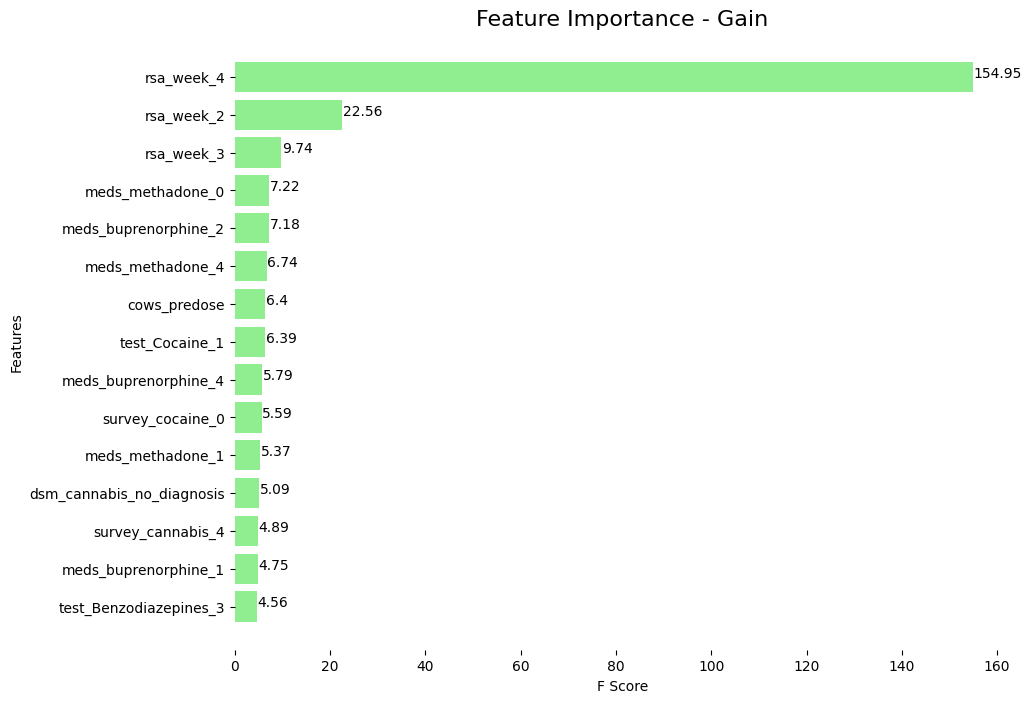

In [57]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Assuming grid_auc.best_estimator_ is your trained XGBoost model
model = grid_auc.best_estimator_

metric='gain'
plot = metric.capitalize().replace('_g', ' G')

# Get feature importances and round them
importances = model.get_booster().get_score(importance_type=metric)
importances_rounded = {k: round(v, 2) for k, v in importances.items()}

# Sort features by importance
sorted_importances = sorted(importances_rounded.items(), key=lambda x: x[1], reverse=True)[:15]

# Separate keys and values for plotting
features, scores = zip(*sorted_importances)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(scores)), scores, color='lightgreen')
plt.yticks(range(len(scores)), features)
plt.xlabel('F Score')
plt.ylabel('Features')
# annotate the values over the bars
for i, v in enumerate(scores):
    plt.text(v + 0.1, i - 0.1, str(v), color='black', va='center')
plt.title(f'Feature Importance - {plot}', fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
# remove borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.show()

## Create a DF with all the trees

In [58]:
# Assuming `grid_auc` is your trained GridSearchCV object with an XGBClassifier
best_model = grid_auc.best_estimator_

# Extract the Booster
booster = best_model.get_booster()

# Convert the trees to a DataFrame
trees_df = booster.trees_to_dataframe().iloc[:, :10]

trees_df = trees_df.sort_values(by='Gain', ascending=False)

In [59]:
trees_df

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
0,0,0,0-0,rsa_week_4,1.0,0-1,0-2,0-2,567.449402,296.470734
15,1,0,1-0,rsa_week_4,1.0,1-1,1-2,1-2,556.575317,296.426788
30,2,0,2-0,rsa_week_4,1.0,2-1,2-2,2-2,545.980225,296.356354
45,3,0,3-0,rsa_week_4,1.0,3-1,3-2,3-2,535.653870,296.260223
60,4,0,4-0,rsa_week_4,1.0,4-1,4-2,4-2,525.586853,296.139221
...,...,...,...,...,...,...,...,...,...,...
69,4,9,4-9,Leaf,NaN,NaN,NaN,NaN,-0.014462,134.267319
54,3,9,3-9,Leaf,NaN,NaN,NaN,NaN,-0.014530,134.976578
39,2,9,2-9,Leaf,NaN,NaN,NaN,NaN,-0.014600,135.680420
24,1,9,1-9,Leaf,NaN,NaN,NaN,NaN,-0.014671,136.378586


In [61]:
trees_df.loc[trees_df['Feature'] == 'meds_methadone_0'][:5]

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
497,33,2,33-2,meds_methadone_0,40.0,33-5,33-6,33-6,14.179871,163.848877
512,34,2,34-2,meds_methadone_0,40.0,34-5,34-6,34-6,13.899643,164.073669
557,37,2,37-2,meds_methadone_0,40.0,37-5,37-6,37-6,13.319649,164.667038
587,39,2,39-2,meds_methadone_0,40.0,39-5,39-6,39-6,12.940613,165.025757
617,41,2,41-2,meds_methadone_0,40.0,41-5,41-6,41-6,12.549240,165.351944


## Plot a Specific Estimator


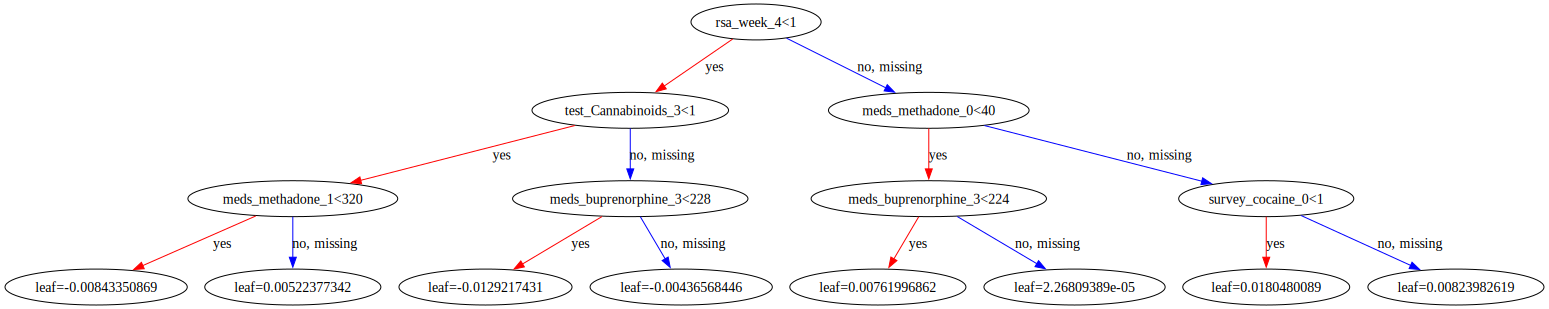

In [62]:
# plot tree with to_graphviz() sideways
graph = xgb.to_graphviz(booster, num_trees=33)
graph

## Analyze Test Set with Predictions

In [63]:
# Assuming `model` is your trained model and `X_test`, `y_test` are your test datasets
predictions = best_gbm.predict(X_test)

# Convert X_test to a DataFrame if it's not already
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)

# Add predictions and actual labels to the DataFrame
X_test_df['Prediction'] = predictions
X_test_df['Actual'] = y_test

# Function to classify each prediction
def classify_prediction(row):
	if row['Prediction'] == row['Actual']:
		return 'TP' if row['Prediction'] == 1 else 'TN'
	else:
		return 'FP' if row['Prediction'] == 1 else 'FN'

# Apply the function to classify predictions
X_test_df['Classification'] = X_test_df.apply(classify_prediction, axis=1)

# Now X_test_df includes the test data, predictions, actual labels, and classification (TP, TN, FP, FN)
test_set = X_test_df

### Analyzing `meds_methadone_4` as a predictor
- We will look at the true positive rate for patients whose methadone dose at week 4 is less than 40
- The model correctly predicted the positive and negative class 80% of the time!<br>

if we look at the test set, we can see patients that test negative for Oxycodone week 1
they are classified as true positive for dropout 46% of the time and true negative 21% of the time


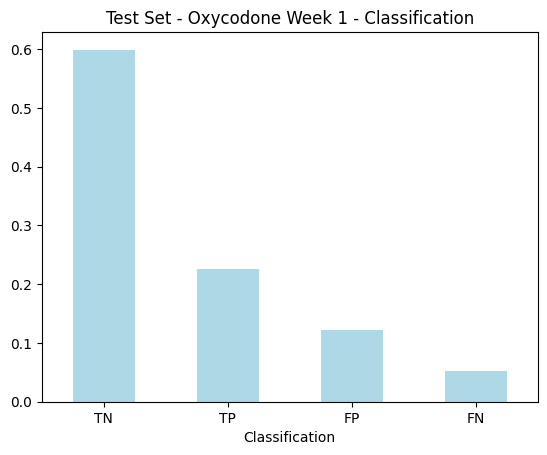

In [65]:
print('if we look at the test set, we can see patients that test negative for Oxycodone week 1')
print('they are classified as true positive for dropout 46% of the time and true negative 21% of the time')
test_set.loc[test_set['meds_methadone_4']<40]['Classification'].value_counts(normalize=True).plot(kind='bar', color='lightblue')
plt.title('Test Set - Oxycodone Week 1 - Classification')
plt.xticks(rotation=0)
plt.show()

## Analyze True Positives for Droput
- 207 patients tested negative for oxycodone week 1
- 46% percent of patients droped out



In [66]:
test_set[test_set['meds_methadone_4']<40]

,test_Amphetamines_0,test_Cannabinoids_0,test_Benzodiazepines_0,test_Cocaine_0,test_Methamphetamine_0,test_Amphetamines_1,test_Cannabinoids_1,test_Benzodiazepines_1,test_Cocaine_1,test_Methamphetamine_1,...,dsm_alcohol_no_diagnosis,dsm_alcohol_not_evaluated,dsm_alcohol_not_present,dsm_amphetamine_dependence,dsm_amphetamine_no_diagnosis,dsm_amphetamine_not_evaluated,dsm_amphetamine_not_present,Prediction,Actual,Classification
427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1.0,TP
1176,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,TN
469,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0.0,TN
120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1.0,TP
371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1.0,TP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,TN
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,TN
1861,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1.0,TP
1361,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,TN


In [68]:

test_set.loc[
    (test_set['meds_methadone_4']<40)& 
    (test_set['Classification']=='TP')
             ][[col for col in test_set.columns if 'dsm_' in col]].sum().sort_values(ascending=False).to_frame('count')[:10]

,count
dsm_opiates_dependence,50.0
dsm_amphetamine_no_diagnosis,49.0
dsm_sedative_no_diagnosis,45.0
dsm_cannabis_no_diagnosis,43.0
dsm_cocaine_no_diagnosis,37.0
dsm_alcohol_no_diagnosis,35.0
dsm_cocaine_dependence,7.0
dsm_sedative_not_present,6.0
dsm_alcohol_not_present,6.0
dsm_opiates_not_present,6.0
